In [1]:
# We import all our dependencies.
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import sys
sys.path.append('../')

from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training

import os
import glob
import zipfile
import urllib
from tifffile import imread, imsave
from matplotlib import pyplot as plt
from tqdm import tqdm

from pathlib import Path
from pystackreg import StackReg
from skimage.transform import warp,AffineTransform
import cv2

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [3]:
def crop_center(img,crop_size):

    if type(crop_size) == tuple:
        crop_x,crop_y = crop_size
    elif type(crop_size) == int:
        crop_x = crop_size
        crop_y = crop_size
    
    y,x = img.shape[-2::]
    startx = x//2-(crop_x//2)
    starty = y//2-(crop_y//2)        

    return img[...,starty:starty+crop_y,startx:startx+crop_x],startx,starty

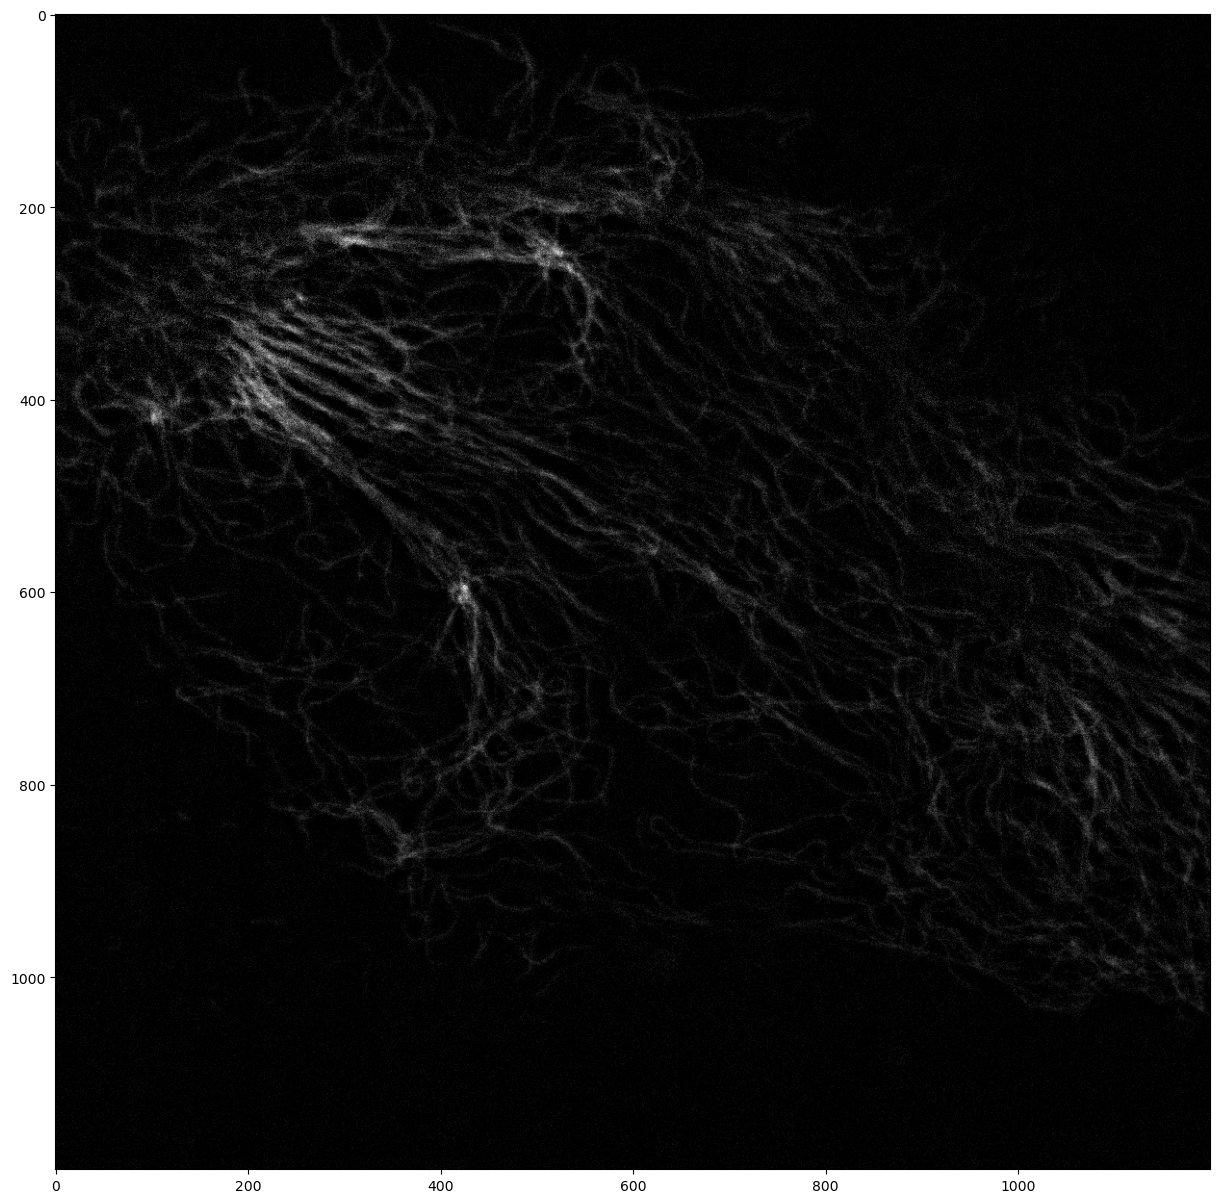

In [4]:
initial_crop_size = 1200
infer_crop_size = 400


# Load img
im_path = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\Evaluation\c14\mltpl_snr\c14_mltpl_snr.tiff")
im = imread(im_path)
im_shape = im.shape

if len(im_shape) == 3:
    timelapse = True
else:
    timelapse = False

im,_,_ = crop_center(im,initial_crop_size)
im[im<-3] = 0

# im = (im-(26.494621) ) / (55.239285) #GMM 1234 NOT BOOTSTRAPPED
# im = (im-(19.723637) ) / (36.286743) #GMM 0
# im = im - np.mean(im) / np.std(im)
if not timelapse:
    plt.figure(figsize=(15,15))
    plt.imshow(im,cmap='gray')
else:
    idx=0
    plt.figure(figsize=(15,15))
    plt.imshow(im[idx],cmap='gray')

In [5]:
# Load model
modelName = "Vim_fixed_mltplSNR_30nm_Noise1234_GMM1234boostrapped_Clip-3_5Lat_6Blocks_betaKL0.02_SupervisedAVG_NoAugment_last_vae"
modelPath = Path("./Trained_model/model/") / (modelName + ".net")


In [6]:
# Inference
margin = 50 # margin on each side in px
num_samples = 10 # number of samples used to compute MMSE estimate
tta = False
gaussian_noise_std = None

model = torch.load(modelPath)
model.mode_pred=True
model.eval()




# single
if not timelapse: 
    im_pad = np.pad(im,(margin,margin))
    samples = np.zeros([num_samples,initial_crop_size,initial_crop_size])
    img_mmse = np.zeros([initial_crop_size,initial_crop_size],dtype='float32')
    for y in range(margin,initial_crop_size-margin,infer_crop_size):
        for x in range(margin,initial_crop_size-margin,infer_crop_size):
            x1 = x-margin
            y1 = y-margin
            x2 = x + infer_crop_size + margin
            y2 = y + infer_crop_size + margin
            try:
                img_mmse_crop, samples_crop = boilerplate.predict(im_pad[y1:y2,x1:x2],num_samples,model,gaussian_noise_std,device,tta)
            except:
                continue

            img_mmse[y-margin:y+infer_crop_size-margin,x-margin:x+infer_crop_size-margin] = img_mmse_crop[margin:-margin,margin:-margin]
            samples[:,y-margin:y+infer_crop_size-margin,x-margin:x+infer_crop_size-margin] = np.stack(samples_crop,axis=0)[:,margin:-margin,margin:-margin]
        
# timelapse
if timelapse:
    list_samples = []
    list_mmse = []

    for frame in im:
        frame_pad = np.pad(frame,(margin,margin))
        samples = np.zeros([num_samples,initial_crop_size,initial_crop_size])
        img_mmse = np.zeros([initial_crop_size,initial_crop_size],dtype='float32')
        for y in range(margin,initial_crop_size-margin,infer_crop_size):
            for x in range(margin,initial_crop_size-margin,infer_crop_size):
                x1 = x-margin
                y1 = y-margin
                x2 = x + infer_crop_size + margin
                y2 = y + infer_crop_size + margin
                # try:
                img_mmse_crop, samples_crop = boilerplate.predict(frame_pad[y1:y2,x1:x2],num_samples,model,gaussian_noise_std,device,tta)
                # except:
                #     continue

                img_mmse[y-margin:y+infer_crop_size-margin,x-margin:x+infer_crop_size-margin] = img_mmse_crop[margin:-margin,margin:-margin]
                samples[:,y-margin:y+infer_crop_size-margin,x-margin:x+infer_crop_size-margin] = np.stack(samples_crop,axis=0)[:,margin:-margin,margin:-margin]
        
        list_samples.append(samples)
        list_mmse.append(img_mmse)

100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


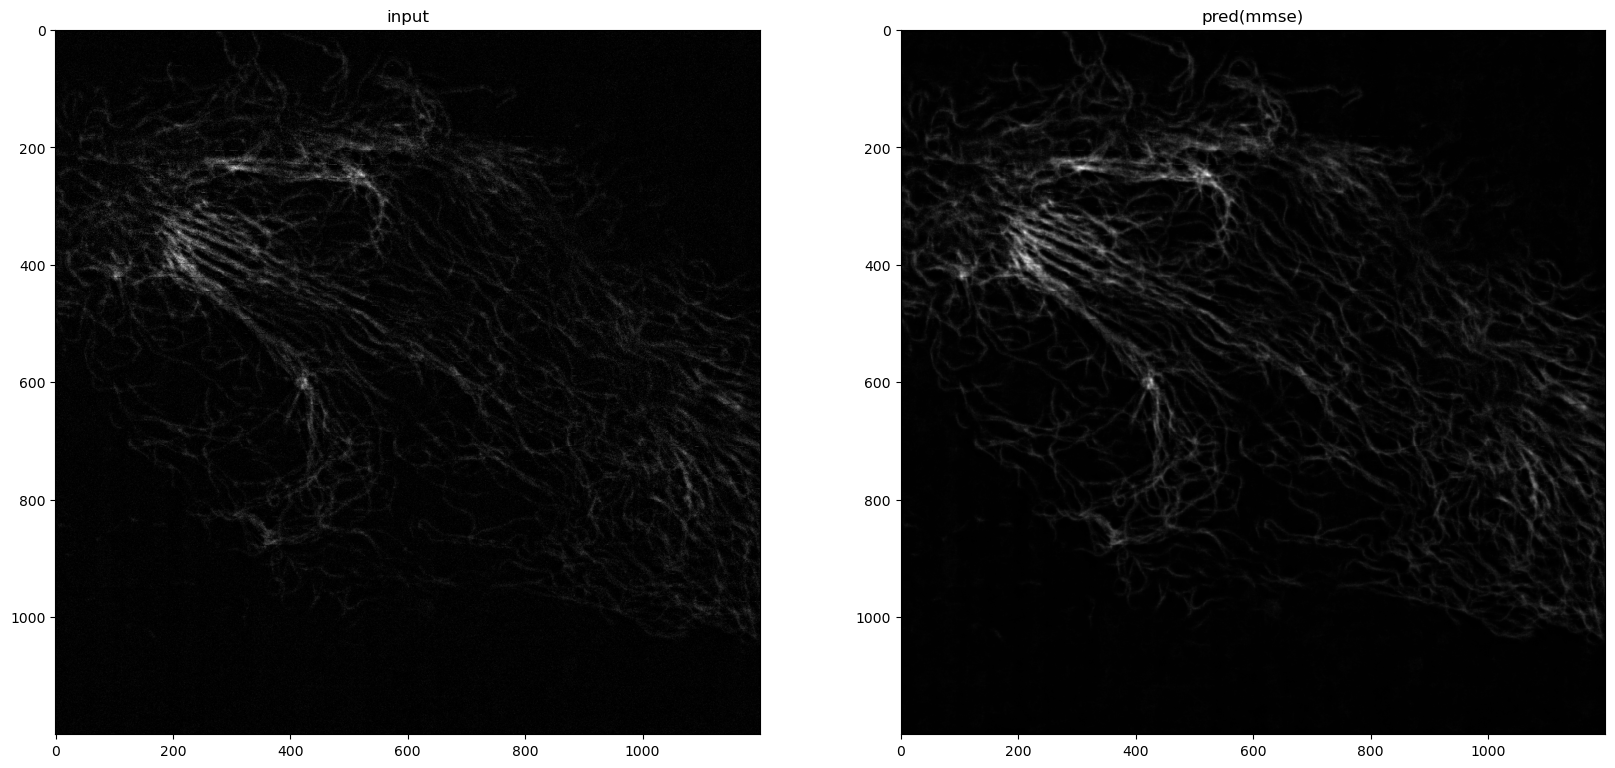

In [7]:
# display

if timelapse:
    idx = 1
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.title("input")
    plt.imshow(im[idx],cmap='gray')
    plt.subplot(1,2,2)
    plt.title("pred(mmse)")
    plt.imshow(list_mmse[idx],cmap='gray')
else:
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.title("input")
    plt.imshow(im,cmap='gray')
    plt.subplot(1,2,2)
    plt.title("pred(mmse)")
    plt.imshow(img_mmse,cmap='gray')

In [8]:
# padding

if not timelapse:
    h=round((im_shape[0] - initial_crop_size) / 2)
    w=round((im_shape[0] - initial_crop_size) / 2)
    img_mmse_pad = np.pad(img_mmse,(h,w))

else:
    h=round((im_shape[1] - initial_crop_size) / 2)
    w=round((im_shape[2] - initial_crop_size) / 2)

    for i,frame in enumerate(list_mmse):
        list_mmse[i] = np.pad(frame,(h,w))

In [9]:
# saving

save_path = im_path.parent / "HDNsup_0.02"
if not os.path.exists(save_path):
    os.makedirs(save_path)

if not timelapse:
    input_path = save_path/ "HDNinp.tiff" 
    mmse_path = save_path / "HDNpred.tiff" 
    mmsePad_path = save_path / "HDNpred_padded.tiff" 
    samples_path = save_path / "HDNsamples.tiff" 
    imsave(input_path,im)
    imsave(mmse_path,img_mmse)
    imsave(mmsePad_path,img_mmse_pad)
    imsave(samples_path,samples)
else:
    mmse_path = save_path / "HDNpred_padded"  
    samples_path = save_path / "HDNsamples" 
    for i in range(len(list_mmse)):
        imsave(f"{mmse_path}_{i}.tiff",list_mmse[i])
        imsave(f"{samples_path}_{i}.tiff",list_samples[i])
